In [1]:
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [2]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt

In [3]:
import torch
import gpytorch
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.sampling.pathwise import draw_kernel_feature_paths

In [4]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        objective_y = objective_function(test_x.view(-1,1)).detach().numpy()
        
        # # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_y, 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        mean = posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy()
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1).cpu().numpy()
        upper = upper.squeeze(-1).squeeze(-1).cpu().numpy()
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8, markersize=20)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), mean, alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower, upper, alpha=0.2)
        # ax.axis("off")

        return objective_y, mean, lower, upper

In [5]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from pandora_bayesopt.utils import fit_gp_model

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40

In [7]:
import numpy as np

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0413]), std = tensor([0.7097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.0248508902119147
Iteration 0, measuring at x=0.365, y=0.029236004042069774


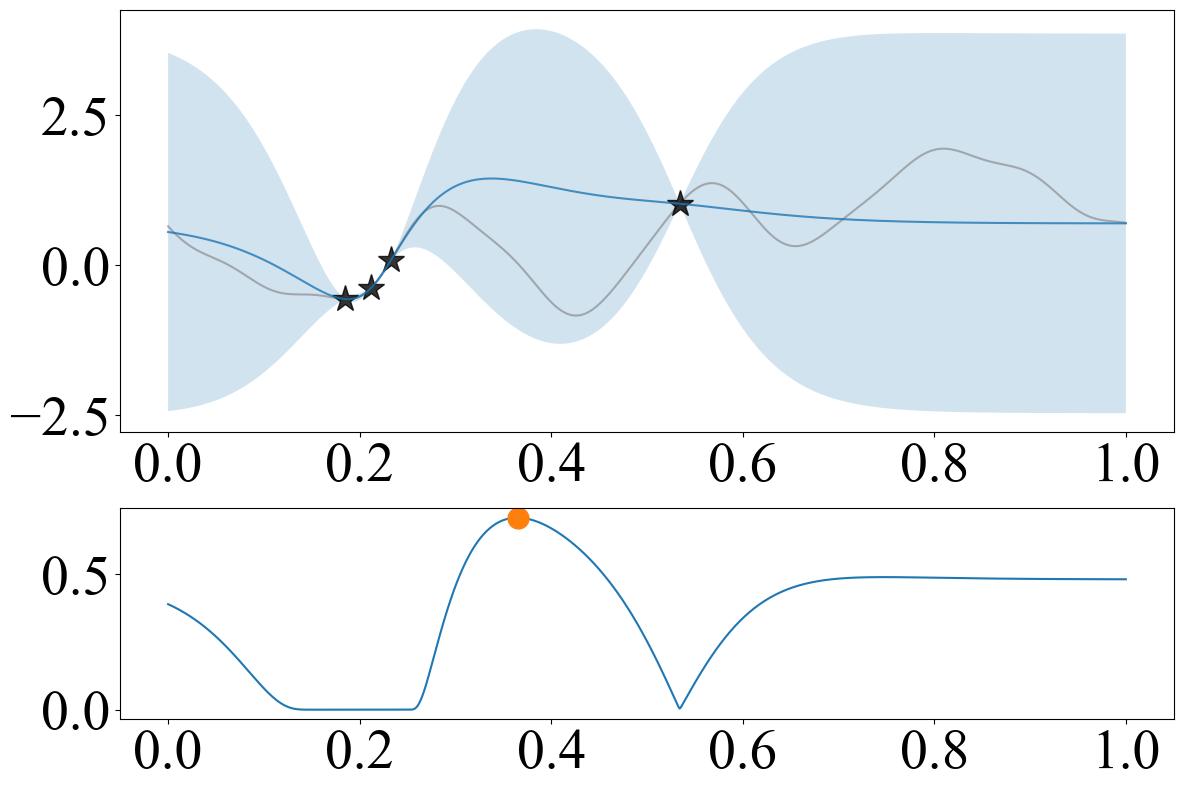

In [8]:
seed = 123
torch.manual_seed(seed)

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

maximize = True

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize EI
BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)

# Plot the posterior and the EI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
objective_y, mean, lower, upper = plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot EI
acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_EI = test_x[torch.argmax(acq)], torch.max(acq)
ax2.plot(test_x.numpy(), acq.detach().numpy(), '-')
ax2.plot(new_point.numpy(), new_point_EI.detach().numpy(),'.', markersize=30)

# Reshape or transpose if necessary (depends on how you want to align them)
arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
np.savetxt('plot/EI_acq.csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()) )
# ax2.axis("off")
plt.tight_layout()
# plt.savefig('plot/EI_acq.pdf', format='pdf')
plt.show()

In [9]:
x.detach().numpy(), y.detach().numpy(), new_point.detach().numpy(), new_point_EI.detach().numpy()

(array([[0.2325852 ],
        [0.21201944],
        [0.18478342],
        [0.53409295]]),
 array([ 0.08212534, -0.37744655, -0.56423412,  1.02485089]),
 array(0.365),
 array(0.70776946))

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0413]), std = tensor([0.7097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.0248508902119147
Iteration 0, measuring at x=0.86, y=1.720476266829563


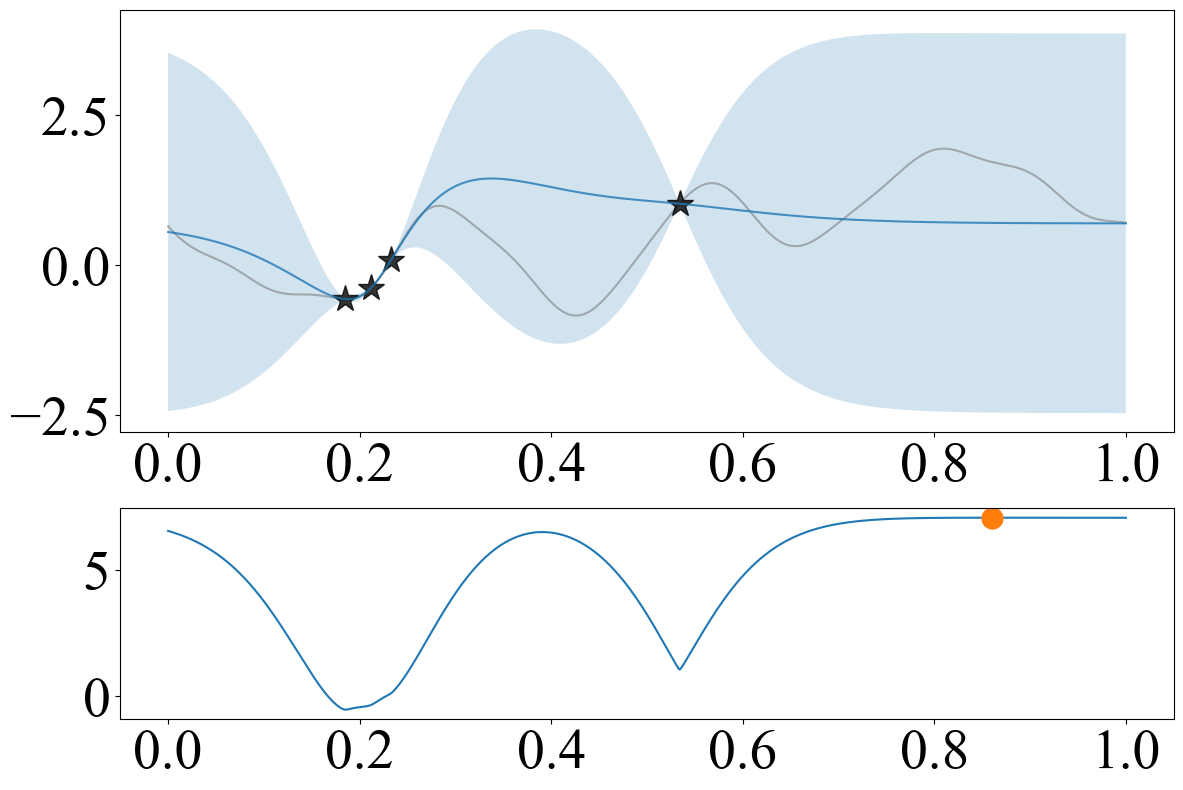

In [10]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex

seed = 123
torch.manual_seed(seed)

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)
lmbda = 0.00001

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

GI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize GI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=lmbda)

# Plot the posterior and the GI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot GI
acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_GI = test_x[torch.argmax(acq)], torch.max(acq)
ax2.plot(test_x.numpy(), acq.detach().numpy(), '-')
ax2.plot(new_point.numpy(), new_point_GI.detach().numpy(),'.', markersize=30)
# ax2.axis("off")
plt.tight_layout()

# Reshape or transpose if necessary (depends on how you want to align them)
arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
np.savetxt('plot/PBGI_acq_small.csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()))
# plt.savefig('plot/PBGI_acq_small.pdf', format='pdf')
plt.show()

In [11]:
x.detach().numpy(), y.detach().numpy(), new_point.detach().numpy(), new_point_GI.detach().numpy()

(array([[0.2325852 ],
        [0.21201944],
        [0.18478342],
        [0.53409295]]),
 array([ 0.08212534, -0.37744655, -0.56423412,  1.02485089]),
 array(0.86),
 array(7.07039997))

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOpt/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0413]), std = tensor([0.7097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 0, measuring at x=0.358, y=0.14411928600969737


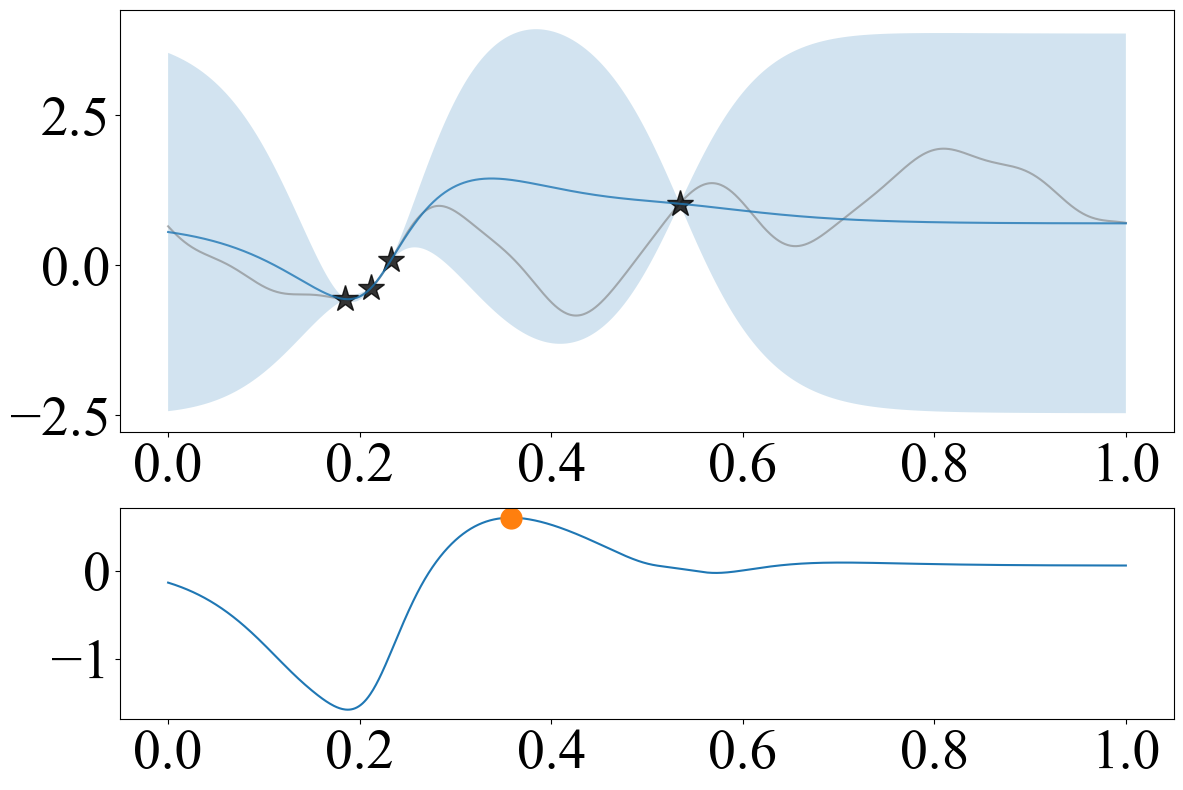

In [12]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex

seed = 123
torch.manual_seed(seed)

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)
lmbda = 1

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

GI_best = [best_f] # This will store the best value
# print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize GI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=lmbda)

# Plot the posterior and the GI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot GI
acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_GI = test_x[torch.argmax(acq)], torch.max(acq)
ax2.plot(test_x.numpy(), acq.detach().numpy(), '-')
ax2.plot(new_point.numpy(), new_point_GI.detach().numpy(),'.', markersize=30)
# ax2.axis("off")
plt.tight_layout()

# Reshape or transpose if necessary (depends on how you want to align them)
arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
np.savetxt('plot/PBGI_acq_large.csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()))
# plt.savefig('plot/PBGI_acq_large.pdf', format='pdf')
plt.show()

In [13]:
x.detach().numpy(), y.detach().numpy(), new_point.detach().numpy(), new_point_GI.detach().numpy()

(array([[0.2325852 ],
        [0.21201944],
        [0.18478342],
        [0.53409295]]),
 array([ 0.08212534, -0.37744655, -0.56423412,  1.02485089]),
 array(0.358),
 array(0.60019592))